# build a model for the dataset


This set of notebooks is based upon 
1. NASA bearing dataset: http://data-acoustics.com/measurements/bearing-faults/bearing-4/
   Set number 2: 4 accelerometers one on each bearing
2. Tutorial: https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

Acknowledgement is made for the measurements used in this work provided through data-acoustics.com database and the python code from a tutorial by Vegard Flovik.

In [1]:
import configparser
import logging
from ocs_sample_library_preview import *
import json

config = configparser.ConfigParser()
config.read('config.ini')

ocsClient = OCSClient(config.get('Access', 'ApiVersion'), config.get('Access', 'Tenant'), config.get('Access', 'Resource'), 
                        config.get('Credentials', 'ClientId'), config.get('Credentials', 'ClientSecret'))
        

namespace_id = config.get('Configurations', 'Namespace')

In [2]:
# notebook specific imports
import os
import datetime
from decimal import Decimal
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

In [3]:
# Retrieve pre-calculated mean values for each channel sample (20480 values)

ocsClient.acceptverbosity=True
signal_datetime = (datetime.datetime.strptime("2004-02-12T10:32:39","%Y-%m-%dT%H:%M:%S"))
df = pd.DataFrame()
for bearing in range(1,5):
    values = ocsClient.Streams.getRangeValues(namespace_id,f'nasa.bearing{bearing}.agg',start=signal_datetime,skip=0,count=985,value_class=None,reverse=False,boundary_type=SdsBoundaryType.Exact)
    df_temp = pd.DataFrame.from_dict(values).set_index('timestamp')
#    df_temp = df_temp.set_index('timestamp')
    df_temp.rename(columns={'channel':f'bearing {bearing}'},inplace=True)
    if df.empty:
        df = df.append(df_temp)
    else:
        df = df.merge(df_temp,on='timestamp')
df.head()

,bearing 1,bearing 2,bearing 3,bearing 4
timestamp,,,,
2004-02-12T10:32:39Z,0.058333,0.071832,0.083244,0.043066
2004-02-12T10:42:39Z,0.058997,0.074008,0.084439,0.044541
2004-02-12T10:52:39Z,0.060240,0.074224,0.083922,0.044443
2004-02-12T11:02:39Z,0.061454,0.073843,0.084462,0.045082
2004-02-12T11:12:39Z,0.061361,0.075607,0.082837,0.045119


# split dataset for testing and training

In [4]:
# includes healhty state
dataset_train = df['2004-02-12 11:02:39':'2004-02-13 23:52:39']
# includes failure state(s)
dataset_test = df['2004-02-13 23:52:39':]

# normalize datasets

In [5]:
# MinMaxScaler re-scale to range [0,1]
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

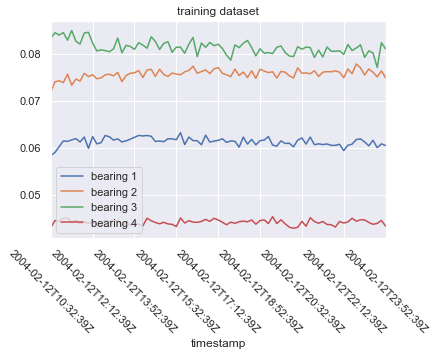

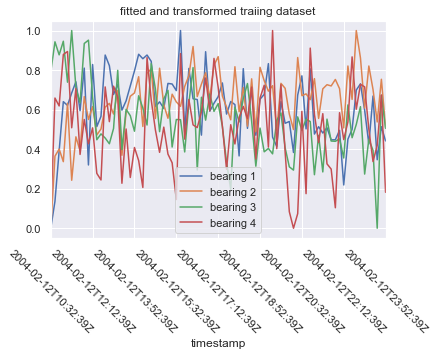

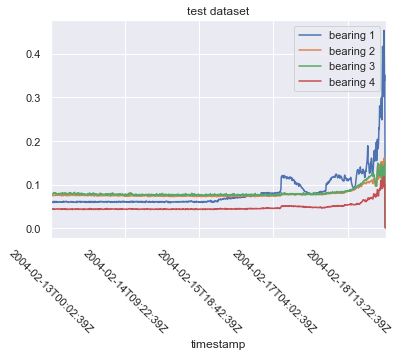

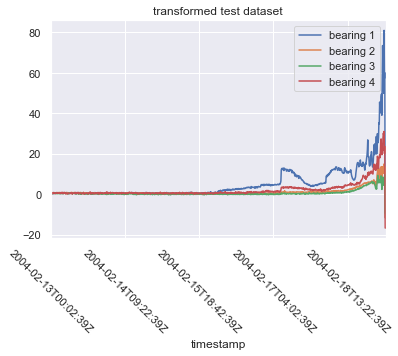

In [6]:
sns.set_style("darkgrid")
sns.set(color_codes=True)
dataset_train.plot(title="training dataset",rot=-45)
X_train.plot(title="fitted and transformed traiing dataset",rot=-45)
dataset_test.plot(title="test dataset",rot=-45)
X_test.plot(title="transformed test dataset",rot=-45)

# compress sensor data down to two principal components

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [8]:
# calculate the covariance matrix

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")
        
# caluclate Mahalanobis distance

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

# outlier detection

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

# threshold for the classificiation beyond which is an anomaly

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

# check if matrix is postive definite

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [9]:
# run it!

cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

# visualizing the square of the Mahalanobis distance

Text(0.5,0,'Square of the Mahalanobis distance')

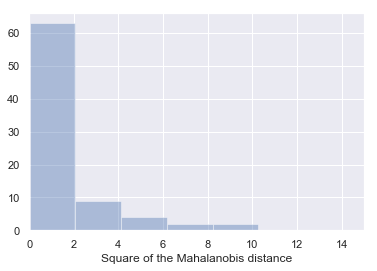

In [10]:
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                'grid.color': 'white',
                'axes.edgecolor': 'black',
                'axes.facecolor': '#EAEAF2'}
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
sns.set_style("darkgrid",rc=custom_style)
sns.reset_defaults()
#sns.reset_orig()
#,rc=custom_style)
sns.set_style("whitegrid")
plt.xlim([0.0,15])
plt.xlabel('Square of the Mahalanobis distance')

# Mahalanobis distance

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Mahalanobis dist')

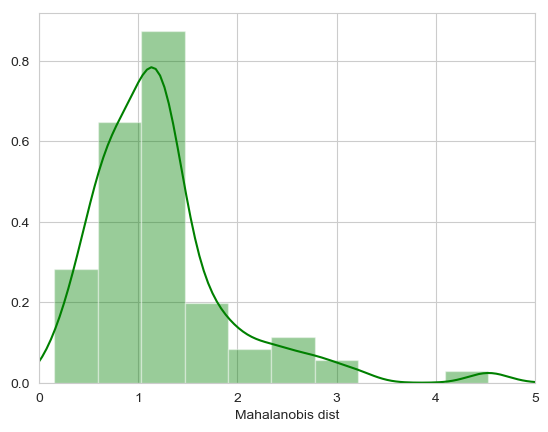

In [11]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [12]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
timestamp,,,
2004-02-13T00:02:39Z,0.823184,3.654354,False
2004-02-13T00:12:39Z,0.786457,3.654354,False
2004-02-13T00:22:39Z,1.129278,3.654354,False
2004-02-13T00:32:39Z,2.336096,3.654354,False
2004-02-13T00:42:39Z,0.871194,3.654354,False


In [ ]:
# save data to a file
#anomaly_alldata = pd.concat([anomaly_train, anomaly])
#anomaly_alldata.to_csv('Anomaly_distance.csv')

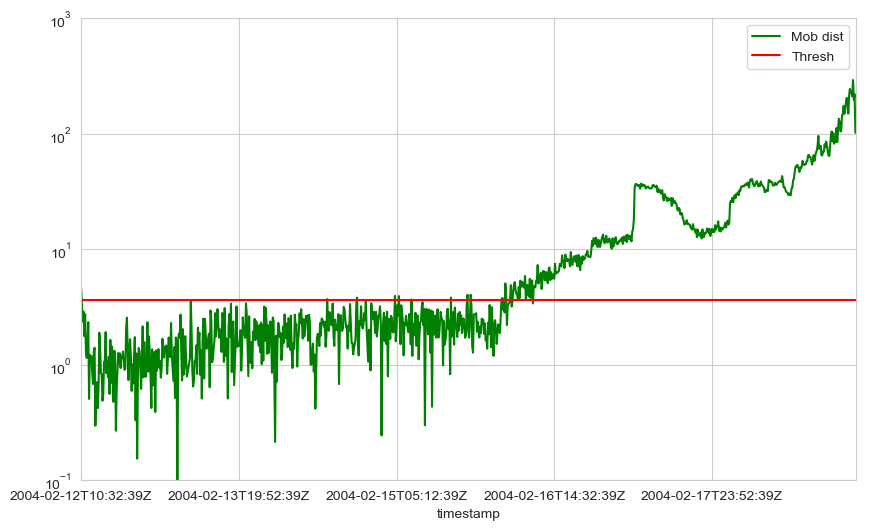

In [14]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])